# Variance of models

After tuning all our models, we made a comparison of their variances, given their individual variability dependent on the choice of the training set.

In [1]:
library(glmnet)
library(keras)
library(xgboost)

data <- read.csv(file.path("..", "data", "training_data.csv"))
data <- na.omit(data)
data_PL <- data$VALENCE.PLEASANTNESS
data$VALENCE.PLEASANTNESS <- NULL
data$SWEETORSOUR <- NULL
data$Intensity <- as.numeric(data$Intensity)

Loading required package: Matrix

Loading required package: foreach

Loaded glmnet 2.0-16




In [2]:
cols = names(data[, sapply(data, function(v) var(v) != 0)])
data <- data[,cols]
dim(data)

[1]  708 3028

In [3]:
set.seed(1)

#define lambda once on a random split training/test
idx <- sample(nrow(data), 4*nrow(data)/5)

#matrix
train.x <- as.matrix(data[idx,])
train.y <- data_PL[idx]

test.x <- as.matrix(data[-idx,])
test.y <- data_PL[-idx]
    
cv.lasso1 <- cv.glmnet(train.x, train.y, alpha = 1, nfold = 10)
l <- cv.lasso1$lambda.min

#cross-evaluate
lasso_cv <- function(seed){
    set.seed(seed)
    idx <- sample(nrow(data), 4*nrow(data)/5)

    #matrix
    train.x <- as.matrix(data[idx,])
    train.y <- data_PL[idx]

    test.x <- as.matrix(data[-idx,])
    test.y <- data_PL[-idx]
     
    best.lasso1 <- glmnet(train.x, train.y, alpha = 1, lambda = l)
    y.pred <- predict(best.lasso1, test.x)
    lasso1.MSE <- mean((y.pred - test.y)^2)
    lasso1.MSE
}
lasso_MSE <- sapply(1:50, lasso_cv)

In [4]:
boost.cv <- function(seed){
    set.seed(seed)
    idx <- sample(nrow(data), 4*nrow(data)/5)

    #matrix
    train.x <- as.matrix(data[idx,])
    train.y <- data_PL[idx]

    test.x <- as.matrix(data[-idx,])
    test.y <- data_PL[-idx]
 
    
    boost.pl <- xgboost(train.x, label=train.y, eta=0.00316227766016838, objective="reg:squarederror", max.depth=3, nrounds=1000, verbose = 0)
    y.pred <- predict(boost.pl, test.x)
    test.error <- mean((y.pred - test.y)^2) 
    test.error
    
}
boost_MSE <- sapply(1:50, boost.cv)

In [5]:
boost.cv2 <- function(seed){
    set.seed(seed)
    idx <- sample(nrow(data), 4*nrow(data)/5)

    #matrix
    train.x <- as.matrix(data[idx,])
    train.y <- data_PL[idx]

    test.x <- as.matrix(data[-idx,])
    test.y <- data_PL[-idx]
     
    boost.pl2 <- xgboost(train.x, label=train.y, eta=0.01, objective="reg:squarederror", max.depth=1, nrounds=2939, verbose = 0)
    y.pred <- predict(boost.pl2, test.x)
    test.error2 <- mean((y.pred - test.y)^2) 
    test.error2
    
}
boost_MSE2 <- sapply(1:50, boost.cv2)

In [6]:
for (i in 1:ncol(data)){
    max <- max(data[,i])
    min <- min(data[,i])
    if (max != 1 & min != 0){
        for (j in 1:nrow(data)) data[j,i] <- (data[j,i]-min) / (max-min)
    }
}

NN_cv <- function(seed){
    set.seed(seed)
    
    idx <- sample(nrow(data), 4*nrow(data)/5)
    train.y <- data_PL[idx]
    test.y <- data_PL[-idx]

    data <- as.matrix(data)
    #training and test scaled predictors sets
    train.x <- data[idx,]
    test.x <- data[-idx,]
    
     nn <- keras_model_sequential() %>%
      layer_dense(units = 600, activation = 'relu', input_shape = c(3028)) %>%
      layer_dense(units = 100, activation = 'relu',) %>%
      layer_dense(units = 1, activation = 'linear')
    
        #train network
        nn %>% compile(
            loss = 'mse',
            optimizer = 'adam'  
        )
        history <- nn %>% fit(
            train.x,
            train.y,
            batch_size = 350, # stochastic gradient descent batch size
            epochs = 650,
            validation_split = 0.25,
            callbacks = callback_early_stopping(monitor = "val_loss", patience = 10)
        )
        y.pred <- predict(nn, test.x) #fixed test set
        MSE <- mean((y.pred - test.y)^2)
        MSE
}

NN_MSE <- sapply(1:50, NN_cv)

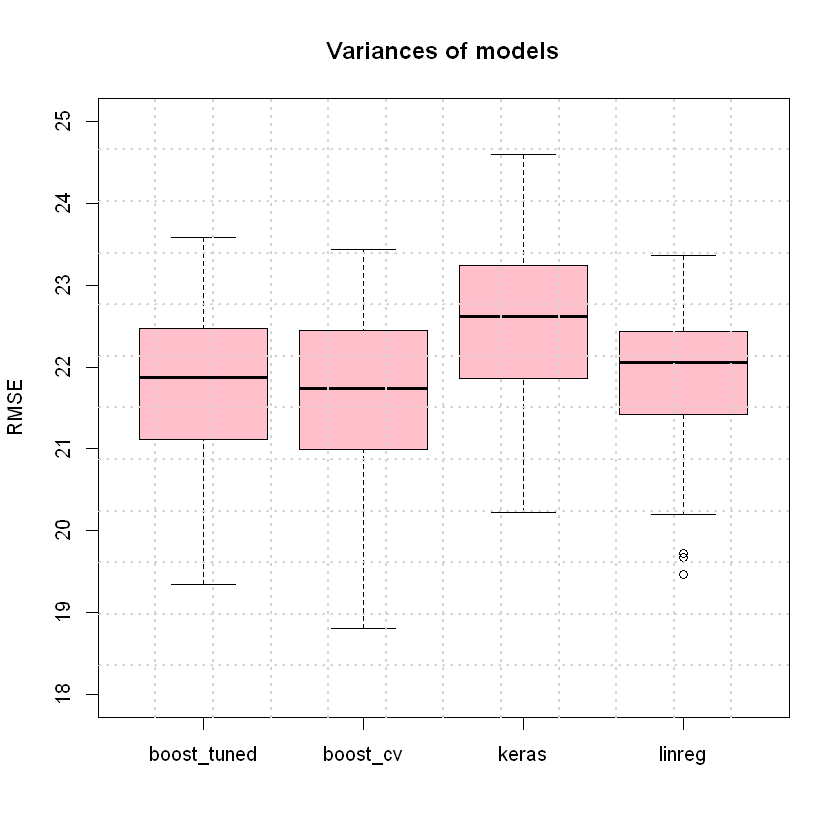

In [8]:
res <- data.frame(boost_tuned = boost_MSE**0.5, boost_cv = boost_MSE2**0.5, keras = NN_MSE**0.5, linreg = lasso_MSE**0.5)
boxplot(res, ylab = "RMSE",  col = 'pink', ylim = c(18, 25))
title('Variances of models')
grid(12, lw = 2)